In [1]:
import numpy as np
import matplotlib.pyplot as plot

In [2]:
raw_imgs = [plot.imread(f"data/{i + 1:02}.png")[:,:,0:3] for i in range(40)]
# row * col * channel
imgs = np.array([img[:, 0:(img.shape[1] // 2), :] for img in raw_imgs])

(240, 320, 3)


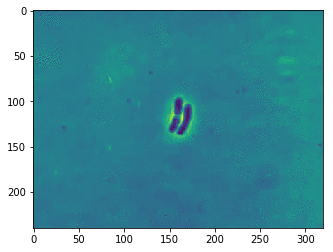

In [3]:
def rgb2intensity(img):
    return 0.2126 * img[:,:,0] + 0.7152 * img[:,:,1] + 0.0722 * img[:,:,2]
img0 = imgs[0]
print(img0.shape)
int0 = rgb2intensity(img0)
plot.imshow(int0)

In [4]:
def mean_std(img):
    return np.mean(img, axis=(0,1)), np.std(img, axis=(0,1))

def lerp(a, b, ctrl):
    return a * ctrl + b * (1.0 - ctrl)

class Norm:
    def __init__(self, img0, momentum=0.9, eps=1e-5):
        self.mean, self.std = mean_std(img0)
        self.momentum = momentum
        self.eps = eps
    def __call__(self, img):
        return (img - self.mean) / (self.std + self.eps)
    def update(self, img):
        new_mean, new_std = mean_std(img)
        self.mean = lerp(self.mean, new_mean, self.momentum)
        self.std = lerp(self.std, new_std, self.momentum)

# common normalizer for later use.
norm = Norm(img0)

In [5]:
def show_channels(img):
    fig, axes = plot.subplots(1, 3)
    for i in range(3):
        ax = axes[i]
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_title('RGB'[i])
        channel = img[:,:,i]
        ax.imshow(channel)
    fig.show()
        
def mask(mask, img, clr_val=0):
    out = np.zeros_like(img)
    if len(out.shape) > 2:
        for i in range(out.shape[2]):
            out[:,:,i] = np.where(mask, img[:,:,i], clr_val)
    else:
        out[:,:] = np.where(mask, img[:,:], clr_val)
    return out

C:\Users\PENGUINLIONG\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


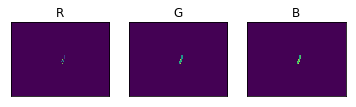

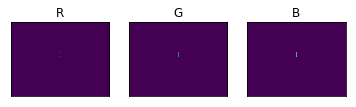

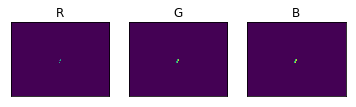

In [6]:
init_masks = [plot.imread(f'data/init-mask.{i + 1}.png') for i in range (3)]
init_masks = np.array([np.max(mask[:,:,:3] > 0, axis=2) for mask in init_masks])

# show the masks.
for i in range(3):
    masked = mask(init_masks[i], img0)
    show_channels(masked)

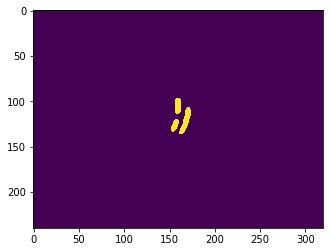

In [7]:
init_particle_idxs = []
for i in range(3):
    (rows, cols) = np.where(init_masks[i])
    for j in range(len(rows)):
        init_particle_idxs.append((rows[j], cols[j]))

validate_img = np.zeros(img0.shape[:2], dtype='float32')
for idx in init_particle_idxs:
    row, col = idx
    validate_img[row, col] = 1.
    
# there should be 3 cells masked.
plot.imshow(validate_img)

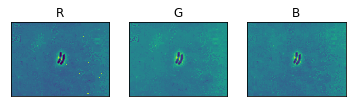

In [8]:
normalized0 = norm(img0)
show_channels(normalized0)

In [9]:
# initialize particles with colors in the first frame.
particles = np.array([img0[row, col] for row, col in init_particle_idxs])

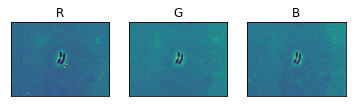

In [10]:
img1 = imgs[1]
normalized1 = norm(img1)
show_channels(normalized1)

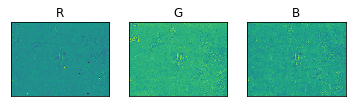

In [11]:
delta_normalized01 = normalized1 - normalized0
show_channels(delta_normalized01)

In [12]:
def img2col(img, wnd_size):
    if (wnd_size % 2 != 1):
        raise RuntimeError("wnd_size must be an odd number")

    nrow, ncol = img.shape
    out = np.zeros((nrow * ncol, wnd_size * wnd_size))
    pad_size = wnd_size // 2
    img = np.pad(img, pad_size, 'constant', constant_values=(0, 0))
    for row in range(nrow):
        for col in range(ncol):
            out[row * ncol + col, :] = img[row:(row + wnd_size), col:(col + wnd_size)].reshape((wnd_size * wnd_size))
    return out

def lk_opflow(img0, img1, wnd_size=5):
    npx = img0.shape[0] * img0.shape[1]
    int0, int1 = rgb2intensity(img0), rgb2intensity(img1)

    dI_dy = np.diff(np.pad(int0, ((1,0),(0,0)), 'constant', constant_values=(0,0)), axis=0)
    dI_dx = np.diff(np.pad(int0, ((0,0),(1,0)), 'constant', constant_values=(0,0)), axis=1)
    dI_dt = int1 - int0

    dI_dx_col, dI_dy_col, dI_dt_col = img2col(dI_dx, wnd_size), img2col(dI_dy, wnd_size), img2col(dI_dt, wnd_size)
    dI2_dxdy = np.sum(dI_dx_col * dI_dy_col, axis=1)
    dI2_dx2 = np.sum(dI_dx_col * dI_dx_col, axis=1)
    dI2_dy2 = np.sum(dI_dy_col * dI_dy_col, axis=1)
    dI2_dxdt = np.sum(dI_dx_col * dI_dt_col, axis=1)
    dI2_dydt = np.sum(dI_dy_col * dI_dt_col, axis=1)

    out = np.zeros((npx, 2))
    for i in range(npx):
        A = np.array([[dI2_dx2[i], dI2_dxdy[i]], [dI2_dxdy[i], dI2_dy2[i]]])
        try:
            A_inv = np.linalg.inv(A)
            out[i] = np.dot(A_inv, np.array([-dI2_dxdt[i], -dI2_dydt[i]])) / wnd_size
        except np.linalg.LinAlgError:
            pass
    return out.reshape(img0.shape[0], img0.shape[1], 2)

In [13]:
FROM = 18
TO = 19

WND = (125,200, 75,175)

dimg = imgs[TO] - imgs[FROM]
opflow = lk_opflow(imgs[FROM], imgs[TO])

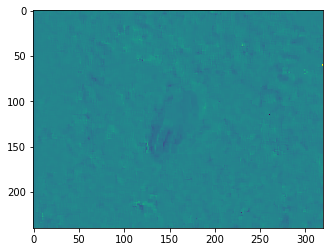

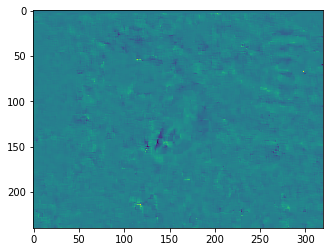

In [15]:
# opflow (x-direction)
plot.imshow(opflow[:,:,0])
plot.show()
# opflow (y-direction)
plot.imshow(opflow[:,:,1])
plot.show()

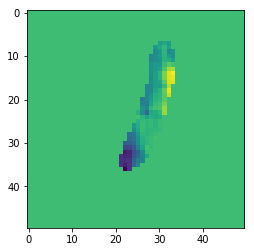

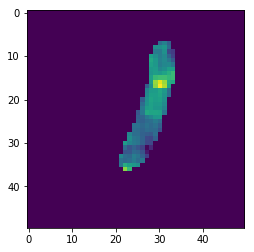

In [16]:
# cell #1
plot.imshow(mask(init_masks[0], opflow[:,:,0])[100:150,140:190])
plot.show()
plot.imshow(mask(init_masks[0], opflow[:,:,1])[100:150,140:190])
plot.show()

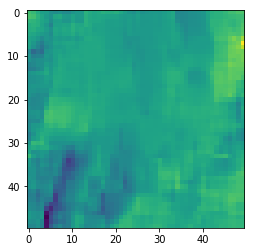

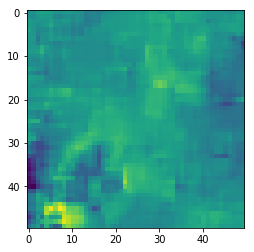

In [17]:
# cell #1 (unmasked)
plot.imshow(opflow[:,:,0][100:150,140:190])
plot.show()
plot.imshow(opflow[:,:,1][100:150,140:190])
plot.show()

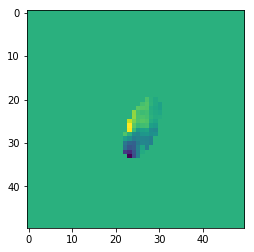

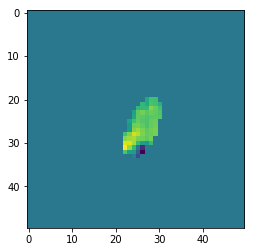

In [18]:
# cell #3.
plot.imshow(mask(init_masks[2], opflow[:,:,0])[100:150,130:180])
plot.show()
plot.imshow(mask(init_masks[2], opflow[:,:,1])[100:150,130:180])
plot.show()

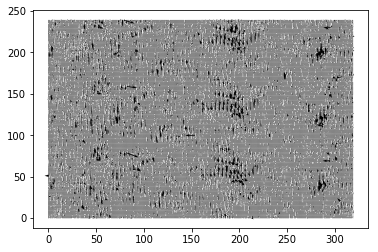

In [19]:
quiver_roots = np.zeros((320, 240, 2))
for i in range(320):
    for j in range(240):
        quiver_roots[i, j, 0] = i
        quiver_roots[i, j, 1] = j
        

plot.quiver(quiver_roots[:,:,0].flatten(), quiver_roots[:,:,1].flatten(), opflow[:,:,0], opflow[:,:,1])